In [1]:
import time
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
def price_barrier_option(option_type: str, ticker: str, K: float | int, barrier_price: float | int) -> float:

    data = yf.download(ticker, start='2022-01-01', end='2025-03-15', progress=False)['Close']['SPY']
    daily_returns = data.pct_change().dropna()

    S0 = float(data.iloc[-1])
    sigma = daily_returns.std() * np.sqrt(252)
    T_days = 252
    r = 0.1
    T = 1  # años
    dt = T / T_days
    num_simulations = 100000

    Z = np.random.normal(0, 1, (num_simulations, T_days))
    payoffs = np.zeros(num_simulations)

    for i in range(num_simulations):
        path = [S0]
        barrier_breached = False
        for t in range(1, T_days + 1):
            St = path[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[i, t-1])
            path.append(St)

            if St > barrier_price:  # up-and-out
                barrier_breached = True
                break

        if not barrier_breached:
            ST = path[-1]
            if option_type == 'put':
                payoffs[i] = max(K - ST, 0)
            else:
                payoffs[i] = max(ST - K, 0)

    price = np.exp(-r * T) * np.mean(payoffs)
    return price

In [3]:
def price_barrier_option_vectorized(option_type, ticker, K, barrier_price):
    # Descargar precios históricos
    data = yf.download(ticker, start='2022-01-01', end='2025-03-15', progress=False)['Close']['SPY']
    daily_returns = data.pct_change().dropna()

    # Parámetros
    S0 = float(data.iloc[-1])
    sigma = daily_returns.std() * np.sqrt(252)
    r = 0.10
    T_days = 252
    T = 1  # años
    dt = T / T_days
    num_simulations = 100000
    Z = np.random.normal(0, 1, (num_simulations, T_days))

    returns = (r - 0.5 * sigma**2) * dt  +  sigma * np.sqrt(dt) * Z
    prices = S0 * np.cumprod(1 + returns, axis=1)

    ST = prices[:, -1]

    barrier_breached = np.any(prices >= barrier_price, axis=1)

    if option_type == 'call':

        payoff_barrier = np.where(~barrier_breached, np.maximum(ST - K, 0), 0 )

        # Payoff opcion sin barrera
        payoff_plain = np.maximum(ST - K, 0)

    elif option_type == 'put':

        payoff_barrier = np.where(~barrier_breached, np.maximum(K - ST, 0), 0 )
        # Payoff opcion sin barrera
        payoff_plain = np.maximum(K - ST, 0)

    price_barrier = np.exp(-r * T) * np.mean(payoff_barrier)
    price_plain = np.exp(-r * T) * np.mean(payoff_plain)
    price_difference = price_plain - price_barrier

    return price_plain, price_barrier

In [4]:
price_barrier_option_vectorized( 'put', 'SPY', 620, 630)

YF.download() has changed argument auto_adjust default to True


(43.26886363368341, 34.792705324940115)

## Ejercicio

1. Con K y option_type fijo, para barrier price desde 0.8`*`K  hasta 1.2`*`K. Grafica el precio de las opciones con y sin barrera.

2. Compara el tiempo de cómputo para 1M de simulaciones entre la opción vectorizada y no vectorizada

### Ejercicio 1

In [5]:
barriers = np.linspace(620, 620*1.2, 20)
plain_prices = []
barrier_prices = []

for barrier in barriers:
    plain_price, barrier_price = price_barrier_option_vectorized('put', 'SPY', 620, barrier)
    plain_prices.append(plain_price)
    barrier_prices.append(barrier_price)

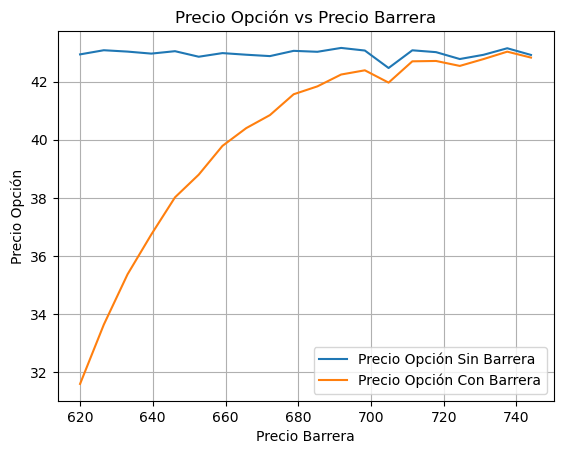

In [6]:
plt.plot(barriers, plain_prices, label='Precio Opción Sin Barrera')
plt.plot(barriers, barrier_prices, label='Precio Opción Con Barrera')
plt.xlabel('Precio Barrera')
plt.ylabel('Precio Opción')
plt.title('Precio Opción vs Precio Barrera')
plt.legend()
plt.grid()

### Ejercicio 2

In [7]:
start_time = time.perf_counter()
price_barrier_option('put', 'SPY', 620, 630)
end_time = time.perf_counter()
print(f"Tiempo de ejecución: {end_time - start_time:.4f} segundos")

Tiempo de ejecución: 18.7995 segundos


In [8]:
start_time = time.perf_counter()
price_barrier_option_vectorized('put', 'SPY', 620, 630)
end_time = time.perf_counter()
print(f"Tiempo de ejecución vectorizado: {end_time - start_time:.4f} segundos")

Tiempo de ejecución vectorizado: 0.5696 segundos


Es aporximadamente 38 veces ás rápido la función vectorizada.